### Analyse DHI Southern North Sea WaterBench
[WaterBench SoutherNorthSea](https://github.com/DHI/WaterBench-MIKE21HD-SouthernNorthSea) \
The notebook analyses the results from the Southern North Sea model calibration. 

##### Import necessary modules

In [ ]:
import warnings
from tqdm import TqdmWarning
warnings.simplefilter("ignore", category=TqdmWarning)

import optuna
import pandas as pd
import modelskill as ms
from pathlib import Path
import mikeio

##### Define optuna database location

In [11]:
study_name = "SNS-Autocalibration"
storage = f"sqlite:///{study_name}.db"

In [12]:
study = optuna.load_study(storage=storage, study_name=study_name)

##### Visualize results

The plot shows how the objective values change as the optimization progresses. Recall that the objective value represents the mean RMSE across individual satellite tracks.

At the start of the optimization, the objective value drops sharply, indicating rapid improvement in the parameter search. After this initial phase, the values gradually level off and converge towards approximately 0.2, reflecting diminishing returns as the optimizer fine-tunes the solution.

This behavior is typical in optimization, where the biggest gains happen early, followed by slow convergence to a stable minimum.

In [13]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_yaxes(range=[0.18, 0.3])
fig.show()

This plot illustrates how individual parameters evolve over the course of the optimization. Notably, parameters such as Manning_zone_2 and Manning_zone_3 tend to stabilize within the range of roughly 40 to 80 m^(1/3)/s, indicating exploitative behavior characteristic of the Gaussian process optimizer.

This locking-in behavior suggests that the optimizer has identified stable values for these parameters, reflecting convergence towards an optimal solution.

In [14]:
optuna.visualization.plot_slice(study)

When inspecting the parameter importance, it becomes evident that the Manning values in zone 2 and zone 6 have the greatest impact on the objective value. This observation is consistent with the zones plot from 1-overview.ipynb, which shows that these zones are located at the northern and southern boundary conditions, respectively—areas that strongly influence the model dynamics.

In [15]:
optuna.visualization.plot_param_importances(study)

##### Show 5 best trials

In [16]:
df = study.trials_dataframe()
df.sort_values('value').head()

,number,value,datetime_start,datetime_complete,duration,params_Manning zone 0,params_Manning zone 1,params_Manning zone 2,params_Manning zone 3,params_Manning zone 4,params_Manning zone 5,params_Manning zone 6,state
67,67,0.199860,2025-07-01 10:51:30.593483,2025-07-01 10:52:18.268794,0 days 00:00:47.675311,81.101,35.621,63.071,81.101,50.951,55.951,81.101,COMPLETE
97,97,0.200345,2025-07-01 11:06:58.248386,2025-07-01 11:07:46.866884,0 days 00:00:48.618498,81.101,34.811,63.411,74.791,51.231,53.891,73.731,COMPLETE
88,88,0.200805,2025-07-01 11:02:13.968183,2025-07-01 11:02:43.318479,0 days 00:00:29.350296,81.101,50.241,64.971,77.401,50.061,55.961,81.101,COMPLETE
83,83,0.201058,2025-07-01 10:59:48.495236,2025-07-01 11:00:17.913675,0 days 00:00:29.418439,81.101,48.501,63.551,77.761,48.901,50.751,81.101,COMPLETE
75,75,0.201082,2025-07-01 10:55:44.863835,2025-07-01 10:56:14.615408,0 days 00:00:29.751573,81.101,45.251,65.461,68.281,52.001,53.021,77.321,COMPLETE


##### Compare water level
The water level of Helgoland is compared from the measurement station and the best trial of the calibration process. The warm up period of the model is excluded from the plot

In [17]:
model_water_level = mikeio.read(Path(r"C:\Users\FSCH\OneDrive - DHI\Workspace\Code\Python\projects\sns_autocalibration\data\best_trial\waterlevels.dfs0"))

observation_water_level = pd.read_csv(r"C:\Users\FSCH\OneDrive - DHI\Workspace\Code\Python\projects\sns_autocalibration\data\observations\Helgoland_wl.csv", index_col=0)
observation_water_level.index = pd.to_datetime(observation_water_level.index, format="ISO8601")

<Axes: title={'center': 'MIKE21 vs Helgoland'}, xlabel='Observation, Surface Elevation [meter]', ylabel='Model, Surface Elevation [meter]'>

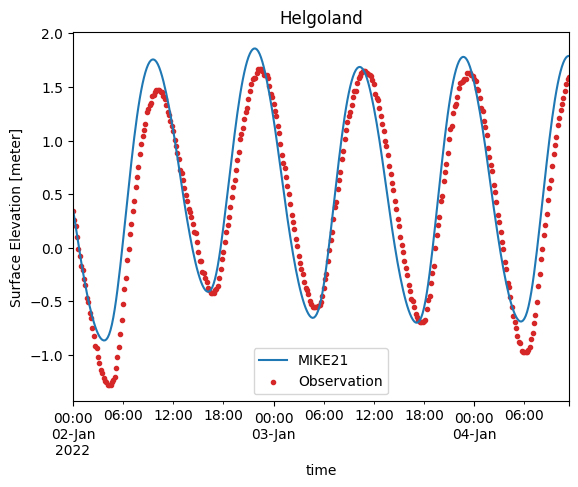

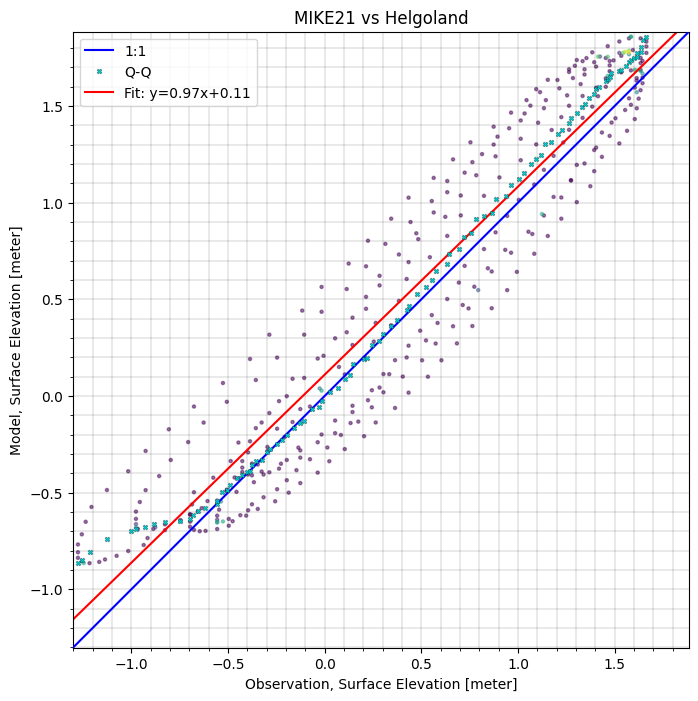

In [18]:
name = "Helgoland"

o = ms.PointObservation(observation_water_level.water_level_filtered, name=name, quantity= ms.Quantity(name="Surface Elevation", unit="meter"))
mr = ms.PointModelResult(model_water_level[o.name+": Surface elevation"], name="MIKE21")

cmp = ms.match(obs=o, mod=mr)
cmp.sel(time=slice("2022-01-02", "2022-01-05")).plot.timeseries()
cmp.sel(time=slice("2022-01-02", "2022-01-05")).plot.scatter()